In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import netCDF4
import numpy as np
import xarray as xr
from cftime import num2pydate
from metpy.units import units
from siphon.catalog import TDSCatalog
from xarray.backends import NetCDF4DataStore

from data import GetGFSData
from indices import CalculateIndices
from charts import CalculateCharts

In [2]:
URL = 'http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/catalog.xml'
dataset = 'Latest Collection for GFS Quarter Degree Forecast'

variables = ['Relative_humidity_isobaric',
             'Temperature_isobaric',
             'u-component_of_wind_isobaric',
             'v-component_of_wind_isobaric',
             'Best_4_layer_Lifted_Index_surface',
             'Geopotential_height_isobaric',
             'Precipitable_water_entire_atmosphere_single_layer']

gfs = GetGFSData(variables)
data = gfs.get()

Process done in 54.907711029052734 seconds


processing


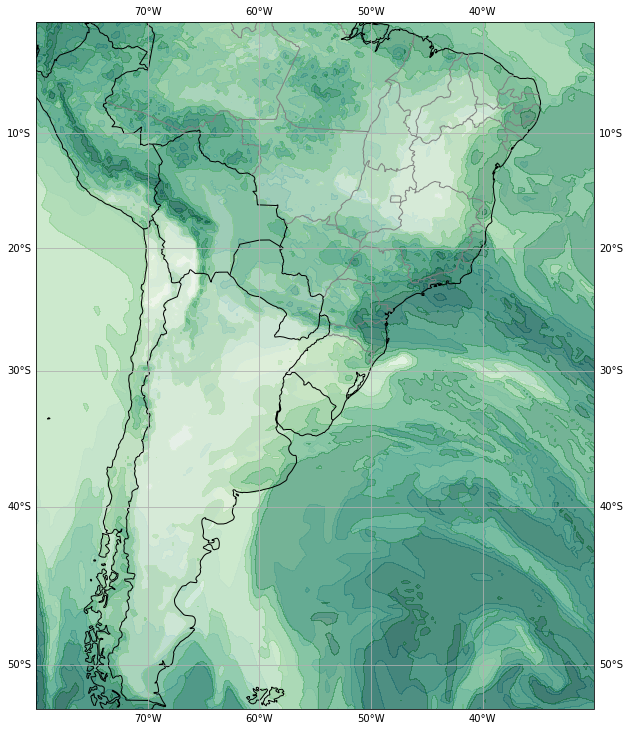

In [3]:
charts = CalculateCharts(data)
humidity = charts.clouds_humidity()